### Simulating a quantum computing network

In this article we are going to implement the Teletransport algorithm in [Netsquid](https://netsquid.org/), showing its capabilities. The explanation of this algorithm can be found on the Internet, on sites like [Qiskit](https://qiskit.org/textbook/ch-algorithms/teleportation.html) tutorial or [Microsoft Community Hub](https://techcommunity.microsoft.com/t5/educator-developer-blog/quantum-teleportation-in-q/ba-p/380602). 

Firstly, we need to register on this [link](https://forum.netsquid.org/ucp.php?mode=register) to get access to the installation package and documentation, registration is free for non-commercial use. After registration and module installation, create a new project or notebook and import the following modules:

In [1]:
import netsquid as ns
from netsquid.nodes.connections import Connection
from netsquid.components.qprogram import QuantumProgram
from netsquid.protocols import NodeProtocol
from netsquid.nodes import Node
from netsquid.components.models.qerrormodels import DephaseNoiseModel
from netsquid.components.models.qerrormodels import DepolarNoiseModel
from netsquid.components.models.delaymodels import FibreDelayModel
from netsquid.components.models.delaymodels import FixedDelayModel
from netsquid.protocols.protocol import Signals
import netsquid.qubits.ketstates as ks
from netsquid.util.datacollector import DataCollector
from netsquid.components.qprocessor import PhysicalInstruction
import pydynaa
from netsquid.components import ClassicalChannel, QuantumChannel
from netsquid.components.qprocessor import QuantumProcessor
from netsquid.nodes.network import Network
from netsquid.qubits.state_sampler import StateSampler
from netsquid.components.qsource import QSource, SourceStatus
import netsquid.components.instructions as instr
import netsquid.qubits.qubitapi as qapi
import pandas

### Creating the infrastructure

After importing the required modules let’s define the simulation infrastructure, composed of quantum computers and channels.

It is possible to define for each computer its processor and memory capacity. For quantum processors we also need to define which instructions will be available. 

For channels, we need to define which computers each channel will connect to and its connection type: classical or quantum.

The above function defines the features of a computer

In [2]:
def create_simulated_computer(depolar_rate, dephase_rate):

    measure_noise_model = DephaseNoiseModel(dephase_rate=dephase_rate, time_independent=True)
    memory_noise_model = DepolarNoiseModel(depolar_rate=depolar_rate)
    
    physical_instructions = [
        PhysicalInstruction(instr.INSTR_INIT, duration=3, parallel=True),
        PhysicalInstruction(instr.INSTR_H, duration=1, parallel=True, topology=[0, 1]),
        PhysicalInstruction(instr.INSTR_X, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_Z, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_S, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_CNOT, duration=4, parallel=True, topology=[(0, 1)]),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[0],
                            quantum_noise_model=measure_noise_model, apply_q_noise_after=False),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[1])
    ]
    
    processor = QuantumProcessor("quantum_processor", 
                                 num_positions=2,
                                 memory_noise_models=[memory_noise_model] * 2,
                                 phys_instructions=physical_instructions)
    return processor

Moving from processor definition to channels, we have to define one classical connection and two quantum connections.

The classical connection features are defined in the class above having inherence with the Connection type:

In [3]:
class ClassicalConnection(Connection):

    def __init__(self, length, name="ClassicalConnection"):
        
        super().__init__(name=name)
        self.add_subcomponent(ClassicalChannel("Channel_A2B", length=length,
                                               models={"delay_model": FibreDelayModel()}),
                              forward_input=[("A", "send")],
                              forward_output=[("B", "recv")])

The quantum connection features are defined in the following class, also having inherence from the Connection type:

In [4]:
class QuantumConnection(Connection):

    def __init__(self, length, source_frequency, name="EntanglingConnection"):
        
        super().__init__(name=name)
        qsource = QSource(f"qsource_{name}", 
                          StateSampler([ks.b00], [1.0]), 
                          num_ports=2,
                          timing_model=FixedDelayModel(delay=1e9 / source_frequency),
                          status=SourceStatus.INTERNAL)
        
        self.add_subcomponent(qsource, name="qsource")

        qchannel_c2a = QuantumChannel("qchannel_C2A", length=length / 2, models={"delay_model": FibreDelayModel()})
        qchannel_c2b = QuantumChannel("qchannel_C2B", length=length / 2, models={"delay_model": FibreDelayModel()})
        
        # Add channels and forward quantum channel output to external port output:
        self.add_subcomponent(qchannel_c2a, forward_output=[("A", "recv")])
        self.add_subcomponent(qchannel_c2b, forward_output=[("B", "recv")])
        
        # Connect qsource output to quantum channel input:
        qsource.ports["qout0"].connect(qchannel_c2a.ports["send"])
        qsource.ports["qout1"].connect(qchannel_c2b.ports["send"])

At this point we have finished the definition of infrastructure using functions and classes.

Let’s use these components to create the network in the next function:

In [5]:
def network_setup(node_distance=4e-3, depolar_rate=1e7, dephase_rate=0.2):

    # Setup nodes Alice and Bob with quantum processor:
    alice = Node("Alice", qmemory=create_simulated_computer(depolar_rate, dephase_rate))
    bob = Node("Bob", qmemory=create_simulated_computer(depolar_rate, dephase_rate))
    
    # Create a network
    network = Network("Teleportation_network")
    network.add_nodes([alice, bob])
    
    # Setup classical connection between nodes:
    c_conn = ClassicalConnection(length=node_distance)
    network.add_connection(alice, 
                           bob, 
                           connection=c_conn, 
                           label="classical",
                           port_name_node1="cout_bob", 
                           port_name_node2="cin_alice")
    
    # Setup entangling connection between nodes:
    source_frequency = 4e4 / node_distance
    
    q_conn = QuantumConnection(length=node_distance, source_frequency=source_frequency)
    
    port_ac, port_bc = network.add_connection(alice, 
                                              bob, 
                                              connection=q_conn, 
                                              label="quantum",
                                              port_name_node1="qin_charlie", 
                                              port_name_node2="qin_charlie")
    
    alice.ports[port_ac].forward_input(alice.qmemory.ports['qin1'])
    bob.ports[port_bc].forward_input(bob.qmemory.ports['qin0'])
    
    return network

### Software Definition

In Netsquid quantum programs, also known as quantum circuits, are defined in classes that have  inherence from the QuantumProgram type. Quantum operations are added to this class to define its behavior.

The following program encodes a value to Alice’s original qubit, which will be transmitted to Bob using the Teletransport Algorithm. 

In [6]:
class InitAliceStateProgram(QuantumProgram):

    default_num_qubits = 1

    def program(self):
        q1, = self.get_qubit_indices(1)
        self.apply(instr.INSTR_INIT, q1)
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_S, q1)
        yield self.run()

A second program executed by Alice implements the first part of the Teletransport Algorithm, using a “CNOT” and a Hadamard gate followed by qubit measurement:

In [7]:
class AliceMeasurementProgram(QuantumProgram):

    default_num_qubits = 2

    def program(self):
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_CNOT, [q1, q2])
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_MEASURE, q1, output_key="M1")
        self.apply(instr.INSTR_MEASURE, q2, output_key="M2")
        yield self.run()

Quantum circuits are executed inside execution flows. Execution flows define the behavior of each node through quantum circuits, communications, and synchronism methods. 

It is derived from NodeProtocol and defines the run method, as the name suggests, to run code that controls iteration among programs, channels, and synchronism methods.

Let’s create a class called AliceMeasurementProtocol to represent the execution flow of Alice. 

In [8]:
class AliceProtocol(NodeProtocol):

    
    def run(self):
        qubit_initialised = False
        entanglement_ready = False
        
        qubit_init_program = InitAliceStateProgram()
        measure_program = AliceMeasurementProgram()
        
        self.node.qmemory.execute_program(qubit_init_program)
        
        while True:
            expr = yield (self.await_program(self.node.qmemory) | 
                          self.await_port_input(self.node.ports["qin_charlie"]))
            if expr.first_term.value:
                qubit_initialised = True
            else:
                entanglement_ready = True
                
            if qubit_initialised and entanglement_ready:
                # Once both qubits arrived, do BSM program and send to Bob
                yield self.node.qmemory.execute_program(measure_program)
                m1, = measure_program.output["M1"]
                m2, = measure_program.output["M2"]
                
                self.node.ports["cout_bob"].tx_output((m1, m2))
                self.send_signal(Signals.SUCCESS)
                
                qubit_initialised = False
                entanglement_ready = False
                
                self.node.qmemory.execute_program(qubit_init_program)

Now let’s define Bob execution flow.

In this flow Bob receives his entangled qubit and data from Alice to decide if he applies any of gates to reconstruct Alice’s qubit state.

In [9]:
class BobProtocol(NodeProtocol):

    
    def run(self):
        
        port_alice = self.node.ports["cin_alice"]
        port_charlie = self.node.ports["qin_charlie"]
        
        entanglement_ready = False
        meas_results = None
        
        while True:
            # Wait for measurement results of Alice or qubit from Charlie to arrive
            expr = yield (self.await_port_input(port_alice) | self.await_port_input(port_charlie))
            if expr.first_term.value:  # If measurements from Alice arrived
                meas_results, = port_alice.rx_input().items
            else:
                entanglement_ready = True
                
            if meas_results is not None and entanglement_ready:
                # Do corrections (blocking)
                if meas_results[0] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_Z)
                    yield self.await_program(self.node.qmemory)
                if meas_results[1] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_X)
                    yield self.await_program(self.node.qmemory)
                    
                self.send_signal(Signals.SUCCESS, 0)
                entanglement_ready = False
                meas_results = None

### Executing the Simulation

The above function collects fidelity data between Alice’s original qubit and the value obtained by Bob using the Teletransport algorithm.

After this definition the code create instances of Alice and Bob protocols and a DataCollector object. The DataColector object is used to store simulation data.

In [10]:
def simulation_setup(node_A, node_B):

    
    def collect_fidelity_data(evexpr):
        
        protocol = evexpr.triggered_events[-1].source
        mem_pos = protocol.get_signal_result(Signals.SUCCESS)
        qubit, = protocol.node.qmemory.pop(mem_pos)
        fidelity = qapi.fidelity(qubit, ns.y0, squared=True)
        qapi.discard(qubit)
        return {"fidelity": fidelity}

    protocol_alice = AliceProtocol(node_A)
    protocol_bob = BobProtocol(node_B)
    dc = DataCollector(collect_fidelity_data)
    dc.collect_on(pydynaa.EventExpression(source=protocol_bob, event_type=Signals.SUCCESS.value))
    return protocol_alice, protocol_bob, dc

Before running the simulation we need to put all pieces together: create the network with nodes and connections, protocols and data collectors.

All these steps are done in the following function, using previously created functions:

In [11]:
def run_experiment(num_runs, depolar_rates, distance=4e-3, dephase_rate=0.0):

    fidelity_data = pandas.DataFrame()
    
    for i, depolar_rate in enumerate(depolar_rates):
        
        ns.sim_reset()
        
        network = network_setup(distance, depolar_rate, dephase_rate)
        node_a = network.get_node("Alice")
        node_b = network.get_node("Bob")
        
        protocol_alice, protocol_bob, dc = simulation_setup(node_a, node_b)
        protocol_alice.start()
        protocol_bob.start()
        
        q_conn = network.get_connection(node_a, node_b, label="quantum")
        cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                         .models["timing_model"].delay)
        
        ns.sim_run(cycle_runtime * num_runs + 1)
        df = dc.dataframe
        df['depolar_rate'] = depolar_rate
        fidelity_data = fidelity_data.append(df)
    return fidelity_data

Finally, we can run the simulation and visualize data collected from it using the above function:

In [12]:
def start_and_plot():
    """Show a plot of fidelity verus depolarization rate.

    """
    from matplotlib import pyplot as plt
    depolar_rates = [1e6 * i for i in range(0, 200, 10)]
    fidelities = run_experiment(num_runs=1000, distance=4e-3,
                                depolar_rates=depolar_rates, dephase_rate=0.0)
    plot_style = {'kind': 'scatter', 'grid': True,
                  'title': "Fidelity of the teleported quantum state"}
    data = fidelities.groupby("depolar_rate")['fidelity'].agg(
        fidelity='mean', sem='sem').reset_index()
    data.plot(x='depolar_rate', y='fidelity', yerr='sem', **plot_style)
    plt.show()

/home/flavio/anaconda3/envs/NetSquid/lib/python3.8/site-packages/netsquid/util/datacollector.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/tmp/ipykernel_14264/254427669.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fidelity_data = fidelity_data.append(df)
/home/flavio/anaconda3/envs/NetSquid/lib/python3.8/site-packages/netsquid/util/datacollector.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/tmp/ipykernel_14264/254427669.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

/home/flavio/anaconda3/envs/NetSquid/lib/python3.8/site-packages/netsquid/util/datacollector.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/tmp/ipykernel_14264/254427669.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fidelity_data = fidelity_data.append(df)
/home/flavio/anaconda3/envs/NetSquid/lib/python3.8/site-packages/netsquid/util/datacollector.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/tmp/ipykernel_14264/254427669.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

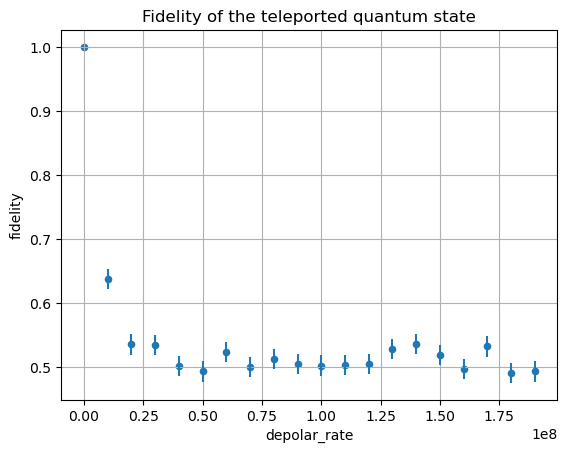

In [13]:
start_and_plot()